# Simplifying the model
Now  I have a model that seems to capture the factors influencing overall drug. But, the model is too complicated to work for individual counties. I'm trying to simplify the model in two ways:
1. Applying a linear model with fewer interactions
2. Merging bins together to make fewer bins 

#### Linear model with fewer interactions
Could a smaller number of interactions do just as well as the full (all-interactions) model? I tried different variants of a logistic regression model. Testing (for variables year, age, yrx (prescriptions per year), yobs (years observed), I tried the simple no-interaction model:

    ~ 1 +C(year) + C(age) +  C(yrx) + C(yobs)

But this does not capture important predictive features.  The pairwise interactions model

    ~ 1 +C(year) + C(age) +  C(yrx) + C(yobs) + 
            C(age)*C(yrx) + C(year)*C(yobs) + C(age)*C(yrx) + C(year)*C(yobs) 
            
Works pretty well. As before, I use a random sampling of people and time periods per person again. Below, each point is a drug, and observed vs expected number of people taking the drug is compared:           

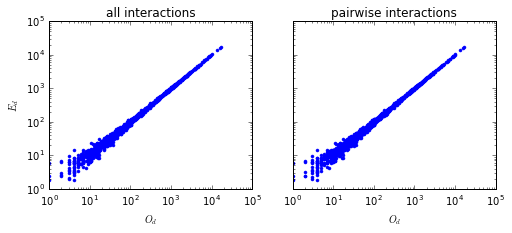

In [16]:
Image(filename='png/obsexp_pairwise.png',width=600)

We can calculate exactly how well the model is doing with deviance ($G_d^2$) for a drug *d*. Given a predicted probability that a person falling into a given bin in a year will take a drug in that year, $p_{d,b}$, and the number of people observed in *b*, $n_b$, and the number of those people taking drug: $y_{d,b}$:
$$ G^2_d = 2 \cdot \sum_{b} y_{d,b} { \cdot log( {y_{d,b} \over {p_{d,b} \cdot n_b }} )} + (n_b - y_{d,b}) { \cdot log( {n_b - y_{d,b} \over {(1 - p_{d,b}) \cdot n_b }} )} $$

Therefore we can calculate deviance for the previous all-interactions model, and for the pairwise interactions model.  Below, the distribution of deviances in the pairwise-interactions model seem to indicate good fit on the training data (all of the observations in the USA), and predictions very close to the all-interaction model:

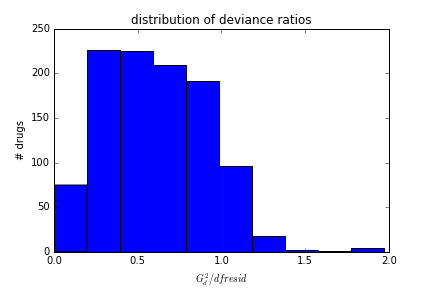

In [3]:
Image(filename='png/g2_drugs.png',width=400)

There are still a few drugs with high deviance (right tail), looking at these, it seems to be the lack of interaction between year and age in my model probably explains the bad fit, so I will add that in:

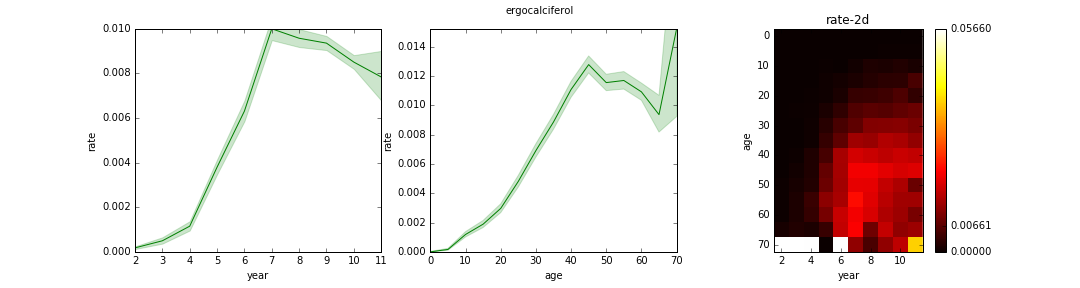

In [5]:
Image(filename='png/ergocalciferol.png',width=800)

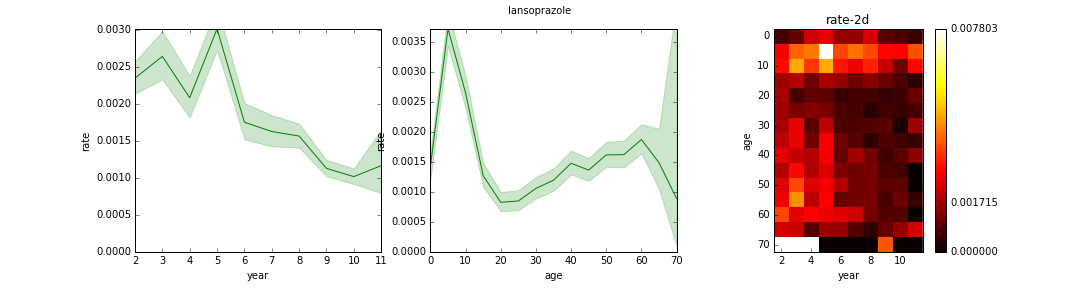

In [6]:
Image(filename='png/lansoprazole.png',width=800)

The training data, being the whole country, does not tell us how well we can predict on a random sample, so I calculate the same value for the random samples, using the number of people sampled per bin, and the number of these taking the drug, as $n_{d,b} y_{d,b}$.  Then, we can directly compare $G_d^2$ between the all-interaction and the some-interaction model, on the random data. Drugs that are  rare are easy to predict and have very low deviance..  so the actual $G_d^2$ values have a wide range across drugs. 

Looking at the change from the all-interactions model to the pairwise model ($\Delta G_d^s$), we can see that the all-interactions model predicts a bit better (lower deviance), but the change is relatively small, considering that thousands more parameters are required:

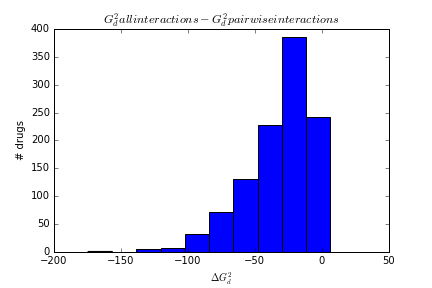

In [11]:
Image(filename='png/deltag.png',width=400)

#### Merging bins 
This is mainly to try to avoid bins with very small counts, but it also reduces the size of the model, especially important when interaction terms are included.  The main culprit for the sparse bins are very few people observed at a given age, year with a large number of prescriptions ( > 20 distinct Rx per year).

I tried to merge these and identify the effect on the model.  Below, from left to right is more merging of bins, with the most-merged having only 12 distinct values for number of Rx/year.  The leftmost bar in each plot represents the number of bins with only One person observed, nationwide.  The question is if this improves or deteriorates our prediction, and if it makes it worse, is it still acceptable.

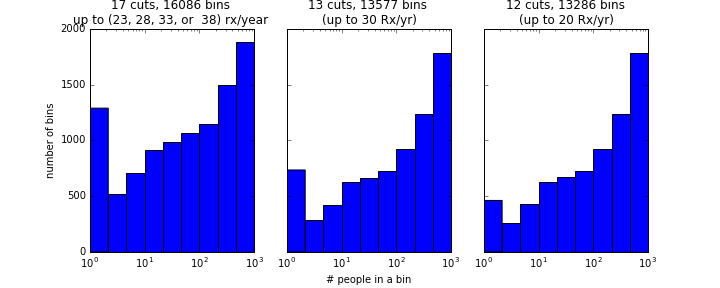

In [17]:
Image(filename='png/mergebins.png',width=700)

Comparing the $G_d^2$ for these variants, there is not a strong shift in the distribution (merge1 = 13 cuts, and merge2 = 12 cuts)

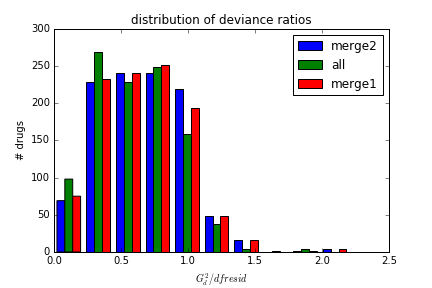

In [9]:
Image(filename='png/G2_comparison.png',width=400)

Since these are not nested models, I'm not sure about comparing the $G_d^2$'s to each other on the training data.  I compared it on the random data, and I find that the merged seems to work much better than unmerged (left plot, the unmerged has a higher deviance on the samples than the merged does, thus the $\Delta G_d^2$ is greater than zero).  The two merged models don't seem very different. 

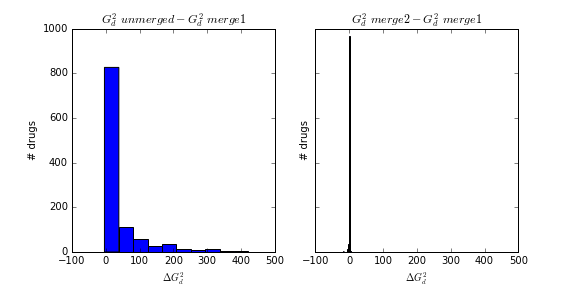

In [13]:
Image(filename='png/mergedeltaG.png',width=600)

## Conclusions
- Simpler logistic regression model with pairwise interactions works well
    - I want to simplify it more with regularization
- Having fewer bins works well

# Predicting drugs after cancer
So far, I've just been showing I can predict drugs in a given year of a patient observation.  But cancer can happen in the middle of the year obviously. As below, the person is diagnosed with cancer in the middle of the year. So she is in a bin with 5 drugs observed per year, but only 3 prescribed after Cancer.  This should affect the probability of actually getting a given drug.

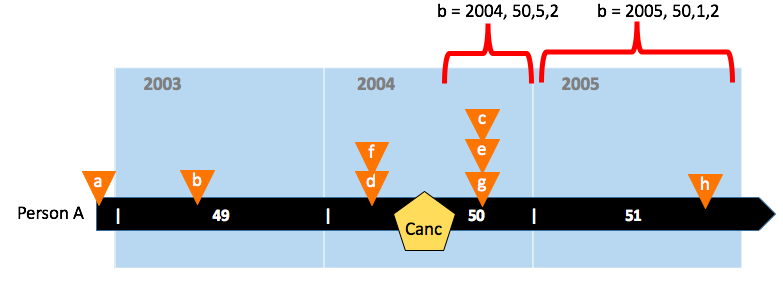

In [19]:
Image(filename='png/partial_year.png',width=600)

Could we just do a linear interpolation of the probability? So the probability for getting drug *d* in the last 3 of the 5 drugs of the year $p_{d,b}' = 3/5*p_{d,b}$

I evaluate this by taking the people in given bin *b*, with 5 drugs, and downsampling to their last 4, 3, 2, and 1 drugs, and see if this estimate of $p_{d,b}'$ is accurate, for a given *d* (here, azithromycin). I also compared it against random shuffling of the order of the drugs. You can see the dashed line representing the linear interpolation is an overestimate in this case, and is similar to the random shufflings. So it seems that prescriptions decline slightly over this year, which we need to account for.

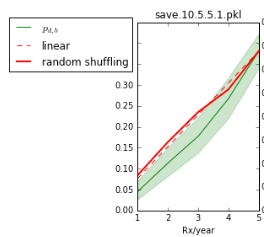

In [23]:
Image(filename='png/partial_year_measure.png',width=400)

In [1]:
from IPython.display import Image